# **Accuweather: Progress Report**

*Quick Recap:* This September we launched an engagement campaign to a selected set of users. We segmented our audience based on the *total event count* in the given month at the time (september). The plots as well as the code used for this purpose can be found [here](https://gist.github.com/sanazgolriz/260a02bcc53393ad4708).

The whole set contained around ~659,433 users with distinct IDs. The level of activity of any given users was divided
into six groups as follows:

| Set Number | Label            | Total Event Count | # of users 
| -------------|:-------------: | ------:| --------:|
| set_one      | un-engaged     |[4-8]        | 468,738 | 
| set_two      | barely engaged |[9-20]       | 10,1915  |
| set_three    | still alive    |[20-30]      |   31006 |
| set_four     | moderately engaged|[30-50]   |   34162 | 
| set_five     | active         |[50-100]     |  18789  |
| set_six      | highly engaged    |[100-1040]|  4823  |


We divided each of these sets into control and treatment group and launched the campaign to those in treatment group. Note that this study is subject to [*non-response bias*](https://en.wikipedia.org/wiki/Non-response_bias) which essentially leads to the fact that the user_sets that we eventually compare will contain *less* elements than what they started simply because some users didn't respond whatsoever. It is interesting to mention that the non-response (as in lack of activity altogether) affected all six sets and both treatment and control groups (just to keep in mind).

| Set Number   | Control [i,f] | Treat Set [i,f]  | 
| -------------|:-------------:| ----------------:| 
| set_one      |   [10000, 3014]    | [458739,138336]| 
| set_two      |   [9000, 3684]    | [92916,38376] |
| set_three    |   [5000, 2237]    | [26007, 11675] |
| set_four     |   [5000, 2169]    | [29163, 12960] |
| set_five     |   [2000, 913]    | [16790, 7938] |
| set_six      |   [500, 282]      | [4325, 2409]   |


*Note: i is for initial: sample size before launch / f is for final: collected sample size after launch*


Here you can see and compare how the control and treatment groups behaved after the launch of the campaigns. This results are compared to the activity rate before the launch of campaign. 



In [7]:
import numpy
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt 
from impala.dbapi import connect
import csv
from __future__ import division
import random 
import matplotlib.legend_handler
import datetime
from collections import Counter, defaultdict
import pandas as pd
import sys
import time 
import yahmm
%matplotlib inline
%install_ext https://raw.githubusercontent.com/meduz/ipython_magics/master/tikzmagic.py
%load_ext tikzmagic

Installed tikzmagic.py. To use it, type:
  %load_ext tikzmagic
The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


In [8]:
# THIS DIRECTLY CONNECTS TO THE DATABASE SO No NEED TO WRITE CSV FILES OUT
conn = connect(host='172.31.31.246', port=21050)
cursor = conn.cursor()


In [9]:
def get_events(setname):

    cursor.execute("""SELECT s.user_id as ID, count(g.event) as final 
                      FROM gallop.%s as s 
                      INNER JOIN 
                      (SELECT user_id, event from gallop.events 
                       WHERE product_id = '4103ddbf-7037-49f0-aea5-40fd905c63e8' 
                       AND year = 2015 and month between 10 and 11 
                       ) as g 
                      ON s.user_id = g.user_id 
                      GROUP BY s.user_id;""" % (setname))
    return cursor.fetchall()


In [10]:
def get_columns(setname,average):
    events = get_events(setname)    
    final = []
    initial = []
    ID = [] 
    for i, item in enumerate(events):
        string_events = ', '.join(map(str, events[i]))
        X = string_events.split(',')
        ID.append(X[0])
        initial.append(average)
        final.append(int(X[1])) 
    return ID, initial, final 



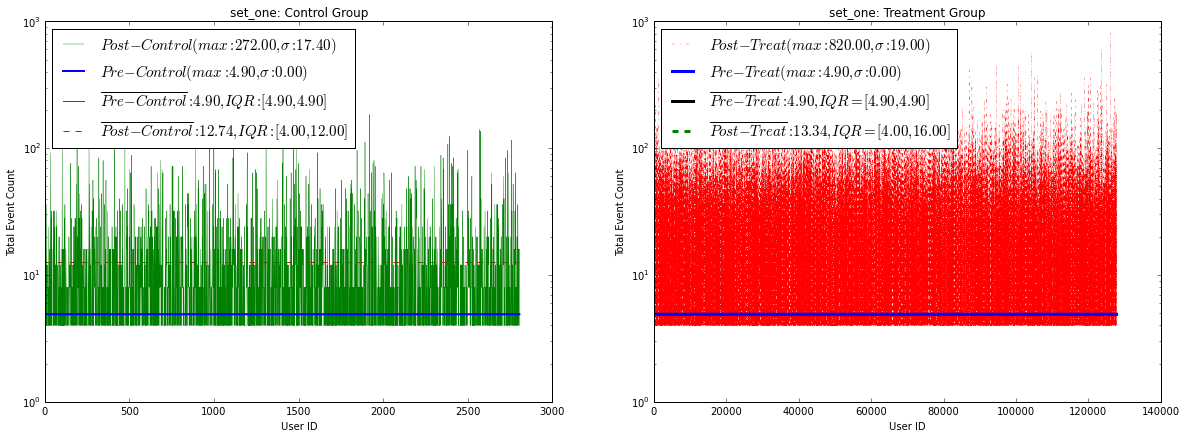

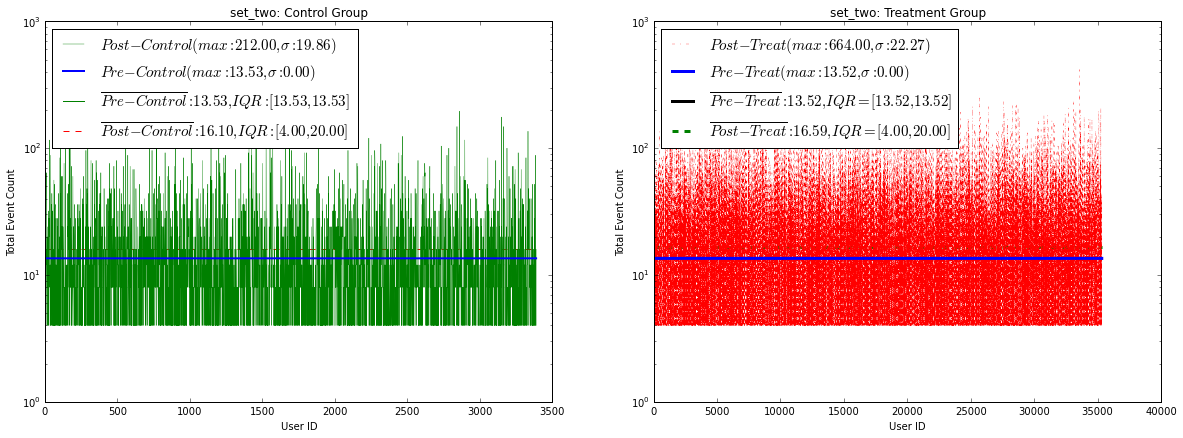

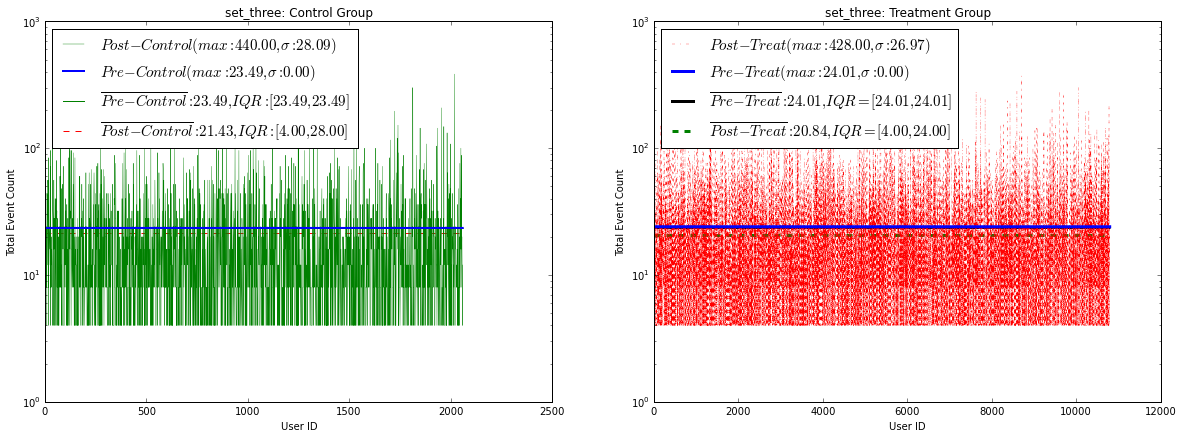

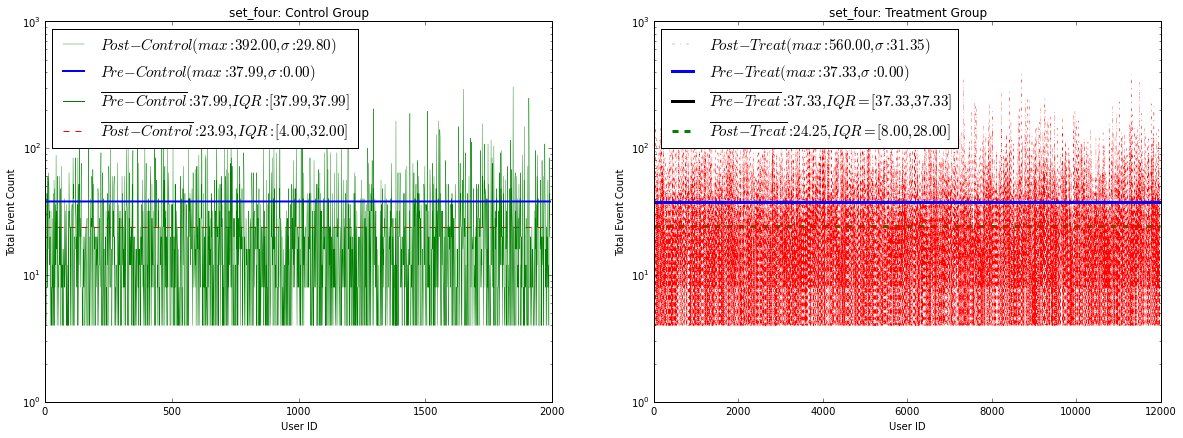

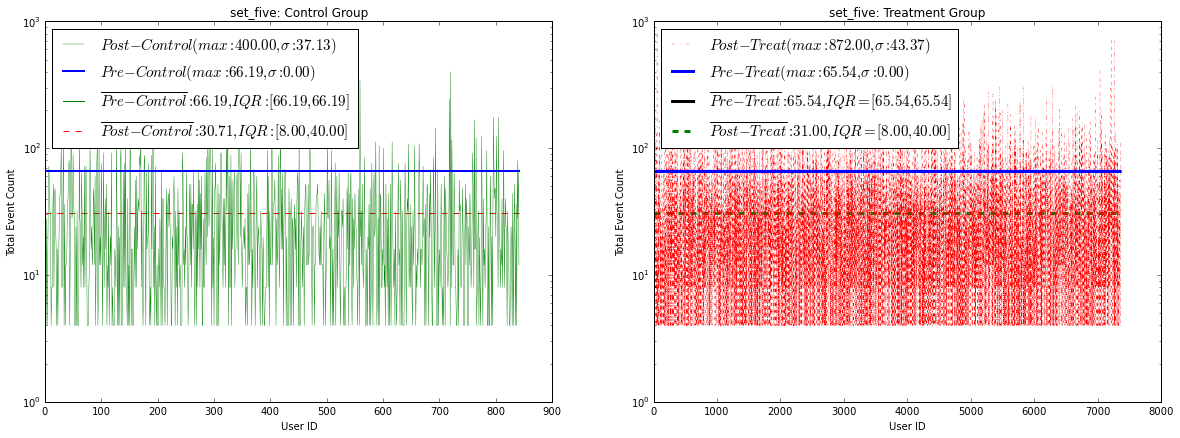

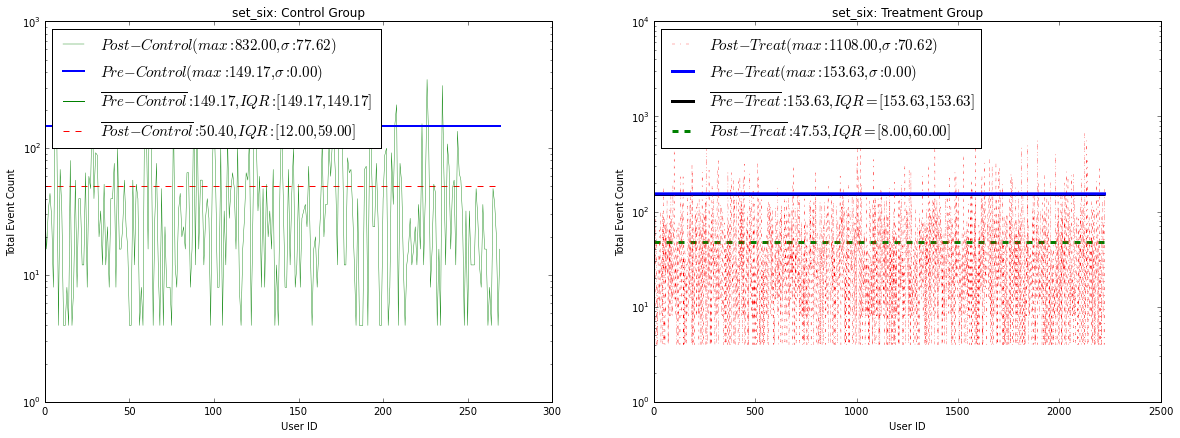

In [16]:
numbers = ['set_one', 'set_two', 'set_three', 'set_four', 'set_five', 'set_six']
Caverage = [4.9,13.53 , 23.49, 37.99, 66.19, 149.17]
Taverage = [4.9, 13.52 , 24.01, 37.33, 65.54, 153.63]

dir = '/Users/sanaz/Documents/Accuweather_Files/Initial_Attempt/Progress_Report/Comparison_Figures/Nov-10-2015/'
gs = gridspec.GridSpec(2,2)

for j, item in enumerate(numbers):
    setnumber = numbers[j]

    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(20)

# ------- Getting the DATA ----------------------
## -------- CONTROL GROUP DATA ------------------
    setname = setnumber + '_control'
    control = get_columns(setname, Caverage[j])
    cID = control[0]
    cinitial = control[1]
    cfinal = control[2]
    cID_index = []
    for i, item in enumerate(cID):
        cID_index.append(i)
        cY1 = cinitial
        cX1 = cID_index
        keydict = dict(zip(cX1,cY1))
        cX1.sort(key=keydict.get)
        sorted_index_control = cX1  
        sorted_initial_control = sorted(cY1)
        sorted_final_control = [] 
    for i, item in enumerate(sorted_index_control):
        sorted_final_control.append(cfinal[sorted_index_control[i]])

    #---------PLOTTING STUFF -------------------------------------
#   font = {'family' : 'normal','weight' : 'bold','size'   : 20}
#    plt.rc('font', **font)


#--------Control 
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(sorted_final_control , color="green", linewidth=0.4, linestyle='-', 
             label = '$Post-Control(max: %.2f, \sigma: %.2f)$' % 
             (numpy.max(sorted_final_control),numpy.std(sorted_final_control)))

    ax1.plot(sorted_initial_control , color="blue", linewidth=2.0,
             label = '$Pre-Control(max: %.2f, \sigma: %.2f)$' % 
             (numpy.max(sorted_initial_control),numpy.std(sorted_initial_control)))

    iqr75_Ca, iqr25_Ca = numpy.percentile(sorted_final_control, [75 ,25])
    iqr75_Cb, iqr25_Cb = numpy.percentile(sorted_initial_control, [75 ,25])

    ax1.set_yscale('log')
    ax1.set_title( setnumber + ': Control Group')
    ax1.set_ylabel('Total Event Count')
    ax1.set_xlabel('User ID')

    ax1.hlines(numpy.mean(sorted_initial_control),min(cID_index),max(cID_index),colors='green', linestyles='solid',
               label='$\overline{Pre-Control}: %.2f , IQR: [%.2f, %.2f] $ ' % 
               (numpy.mean(sorted_initial_control),iqr25_Cb ,iqr75_Cb))

    ax1.hlines(numpy.mean(sorted_final_control),min(cID_index),max(cID_index),colors='red', linestyles='--',
               label='$\overline{Post-Control}: %.2f , IQR: [%.2f, %.2f]$' % 
               (numpy.mean(sorted_final_control),iqr25_Ca ,iqr75_Ca))

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles,labels, prop={'size':15}, loc='upper left')

#------------------Treatment 
    
##-------------------------------------------------
## -------- TREATMENT GROUP DATA ------------------
    setname = setnumber + '_treat'
    treat = get_columns(setname, Taverage[j])
    tID = treat[0]
    tinitial = treat[1]
    tfinal = treat[2]
    tID_index = []
    for i, item in enumerate(tID):
        tID_index.append(i)
        tY1 = tinitial
        tX1 = tID_index
        keydict = dict(zip(tX1,tY1))
        tX1.sort(key=keydict.get)
        sorted_index_treat = tX1  
        sorted_initial_treat = sorted(tY1)
        sorted_final_treat = [] 
    for i, item in enumerate(sorted_index_treat):
        sorted_final_treat.append(tfinal[sorted_index_treat[i]])
    
    
    iqr75_Ta, iqr25_Ta = numpy.percentile(sorted_final_treat, [75 ,25])
    iqr75_Tb, iqr25_Tb = numpy.percentile(sorted_initial_treat, [75 ,25])

    ax2 = fig.add_subplot(gs[0,1])
    ax2.plot(sorted_final_treat, color="red", linewidth=0.3, linestyle='-.', 
             label='$Post-Treat(max: %.2f, \sigma: %.2f)$' %
             (numpy.max(sorted_final_treat),numpy.std(sorted_final_treat)))
         
    ax2.plot(sorted_initial_treat , color="blue", linewidth=3.0, linestyle = '-',
             label='$Pre-Treat(max: %.2f, \sigma: %.2f)$' % 
             (numpy.max(sorted_initial_treat),numpy.std(sorted_initial_treat)))
    ax2.set_yscale('log')
    ax2.set_title(setnumber + ': Treatment Group')
    ax2.set_ylabel('Total Event Count')
    ax2.set_xlabel('User ID')
    ax2.hlines(numpy.mean(sorted_initial_treat),min(tID_index),max(tID_index),colors='black', linewidth=3, 
               linestyles='solid',label='$\overline{Pre-Treat}: %.2f , IQR = [%.2f, %.2f]$' %
               (numpy.mean(sorted_initial_treat), iqr25_Tb , iqr75_Tb))
    ax2.hlines(numpy.mean(sorted_final_treat),min(tID_index),max(tID_index),colors='green', linewidth=3, 
               linestyles='--',label='$\overline{Post-Treat}: %.2f , IQR = [%.2f, %.2f]$' %
               (numpy.mean(sorted_final_treat), iqr25_Ta,iqr75_Ta))
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles,labels, prop={'size':15}, loc='upper left')
 #   fig.savefig(dir + setnumber)
    